# Workshop Example: Predicting Ion Concentrations in Delta

**Disclaimer:** This notebook is created for educational purposes as part of a machine learning workshop. The models and methods demonstrated here are simplified examples and not necessarily optimized for production use. The actual models used in production environments may incorporate additional features, more sophisticated techniques, and more extensive validation.

In this workshop, we'll walk through a machine learning workflow using water ion data from the California Delta. We'll focus on predicting Bromine (Br) concentration based on various predictors including both numerical variables (like Electrical Conductivity) and categorical variables (like location and water year type).

### Workflow Overview:
1. **Data Loading**: Import and initial processing of water quality datasets
2. **Data Visualization**: Explore relationships between variables
3. **Preprocessing**: Feature engineering, scaling, and encoding
4. **Model Training**: Implement and train multiple models (Random Forest, XGBoost, Neural Network)
5. **Model Evaluation**: Compare performance across models
6. **Interactive Dashboard**: Create a user-friendly interface for predictions

This example demonstrates how machine learning can be applied to environmental data to create predictive tools that support water management decision-making.
**For questions or feedback, please contact:**  
Peyman Namadi (peyman.hosseinzadehnamadi@water.ca.gov)


Copyright © 2025 State of California, Department of Water Resources. All Rights Reserved.
This script is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
Reproduction or distribution of this script without permission is prohibited.

## Section 0: Setup and Library Imports

In [ ]:
!pip install hvplot holoviews panel
!pip install jupyter_bokeh

In [ ]:
# ================= SECTION 0: IMPORT LIBRARIES =================
# Core data handling and analysis
import pandas as pd
import numpy as np
import os
import joblib
from datetime import datetime

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas
import holoviews as hv
import panel as pn

# Machine learning libraries
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Set default styles for visualizations
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 10})

## 1. Data Loading

In [ ]:
import pandas as pd
import os

# Mount Google Drive (needed to access files in Colab)
from google.colab import drive
drive.mount('/content/drive')

# Define the paths to the input and output folders on Google Drive
input_folder = '/content/drive/MyDrive/WorkshopML_Colab/inputs'
output_folder = '/content/drive/MyDrive/WorkshopML_Colab/outputs'

# Create directories if they don't exist
os.makedirs(input_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

# List of ion files to load
ions = ['Alkalinity', 'Br', 'Ca', 'Cl', 'K', 'Mg', 'Na', 'SO4', 'TDS']

# Dictionary to store our dataframes
ion_dfs = {}

# Load each ion dataset from CSV
for ion in ions:
    # Construct the file path
    file_path = os.path.join(input_folder, f"{ion}.csv")

    # Load the CSV if it exists
    if os.path.exists(file_path):
        # Read the CSV file
        df = pd.read_csv(file_path)
        print(f"Loaded {ion} dataset: {df.shape[0]} rows, {df.shape[1]} columns")

        # Convert Collection Date to datetime
        df['Collection Date'] = pd.to_datetime(df['Collection Date'])

        # Set categorical variables
        if 'Location' in df.columns:
            df['Location'] = df['Location'].astype('category')
        if 'WYT' in df.columns:
            df['WYT'] = df['WYT'].astype('category')

        # Store in both a dictionary and as a global variable with the same name as the ion
        ion_dfs[ion] = df
        globals()[ion] = df
    else:
        print(f"Warning: Could not find {ion}.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded Alkalinity dataset: 1033 rows, 7 columns
Loaded Br dataset: 1236 rows, 7 columns
Loaded Ca dataset: 1325 rows, 7 columns
Loaded Cl dataset: 1951 rows, 7 columns
Loaded K dataset: 1138 rows, 7 columns
Loaded Mg dataset: 1326 rows, 7 columns
Loaded Na dataset: 1561 rows, 7 columns
Loaded SO4 dataset: 1068 rows, 7 columns
Loaded TDS dataset: 1447 rows, 7 columns


## 2. Visualization

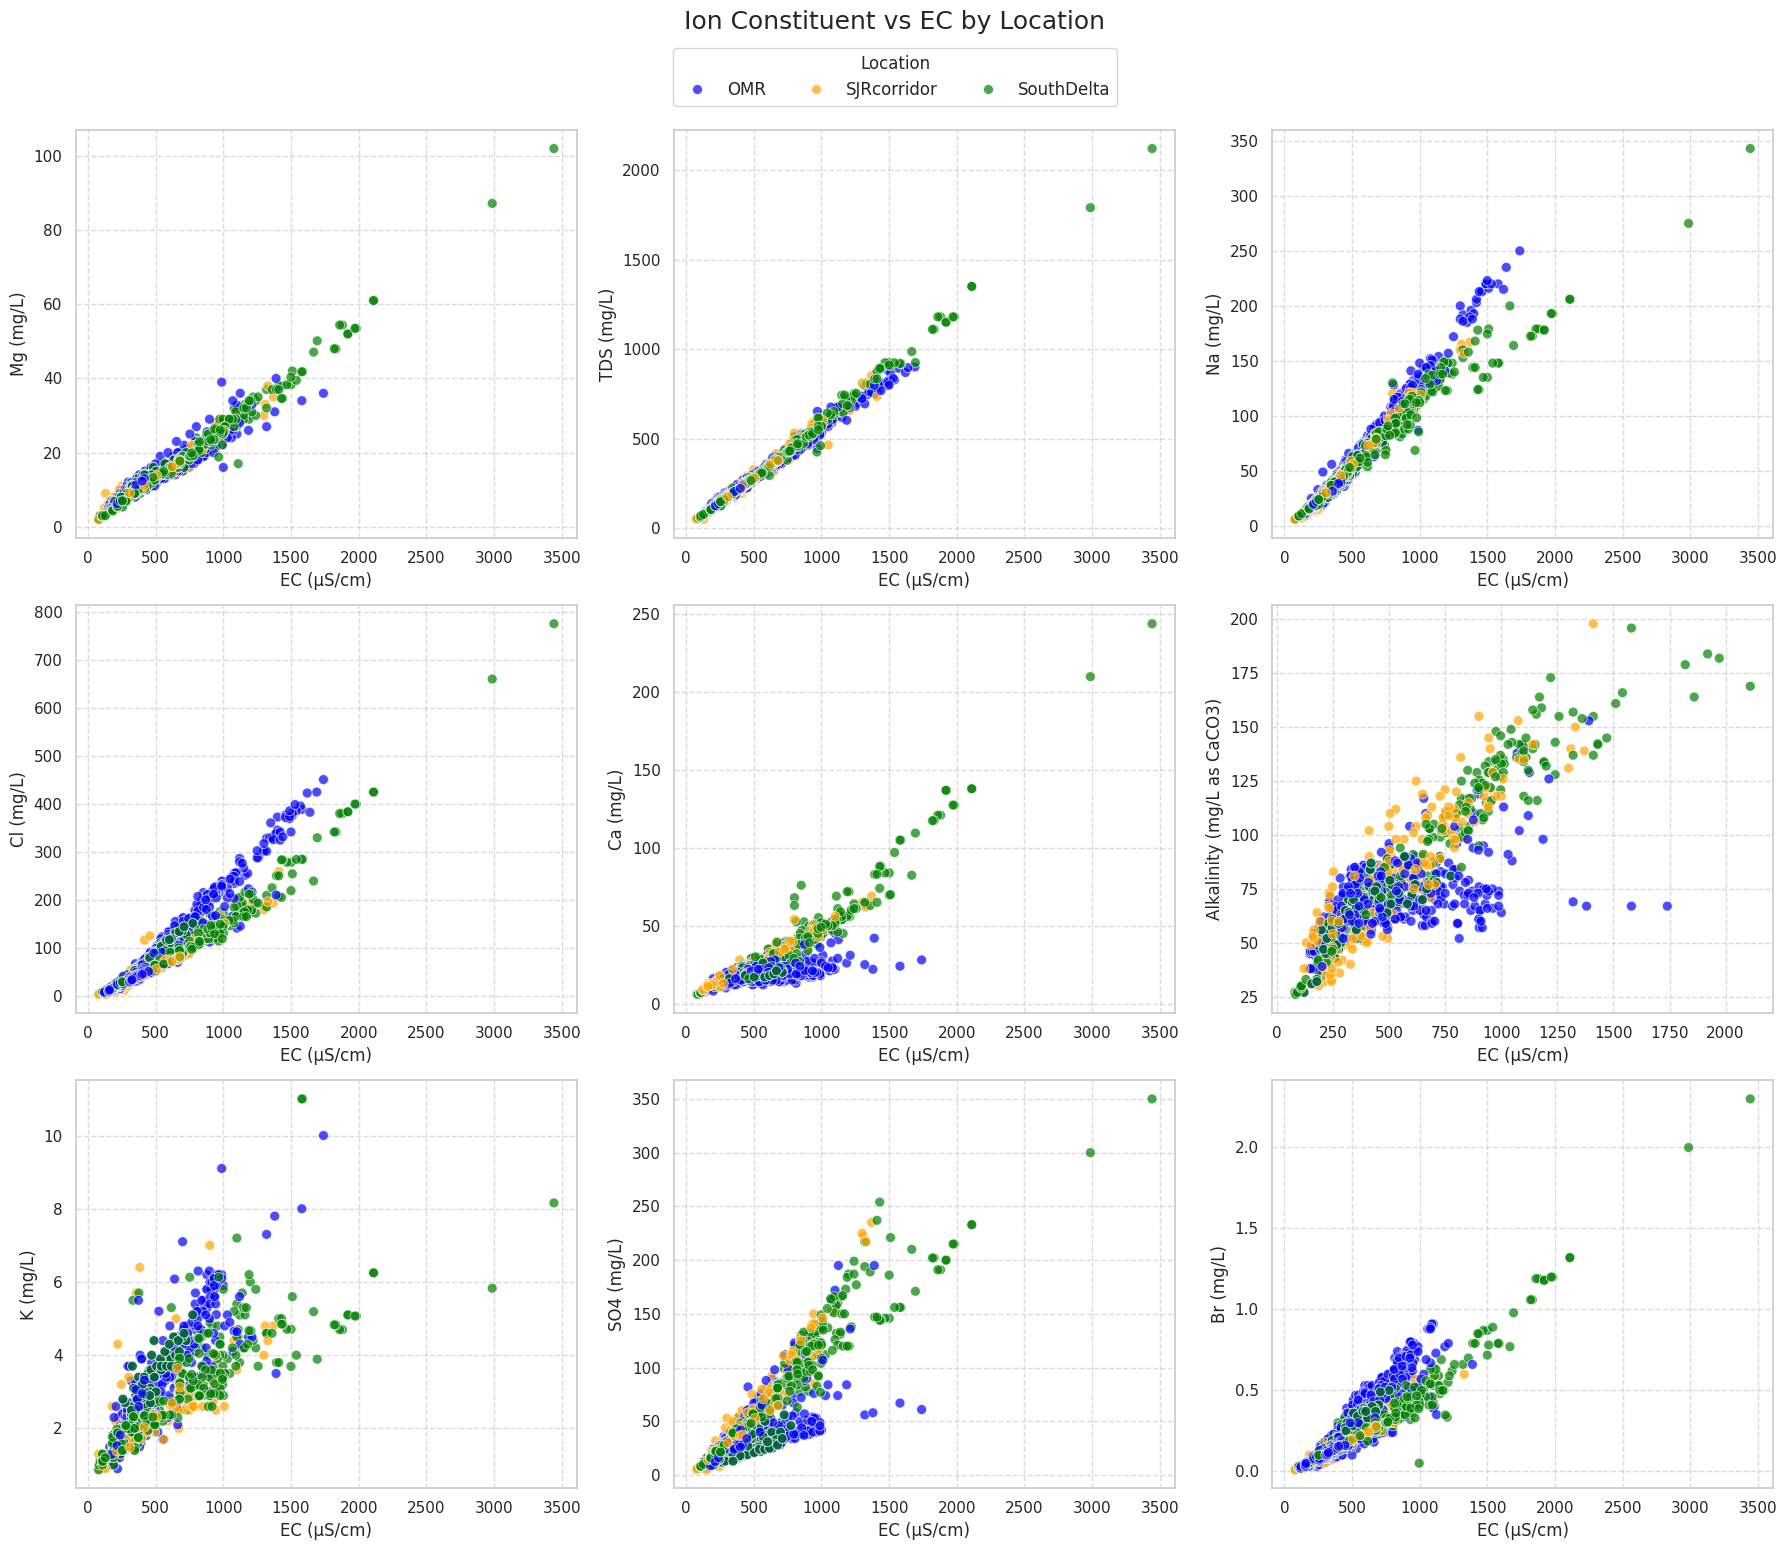

In [ ]:
# Set the visualization style
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 10})

# Define the ions and their units for plotting
ions_info = {
   'Mg': 'mg/L',
   'TDS': 'mg/L',
   'Na': 'mg/L',
   'Cl': 'mg/L',
   'Ca': 'mg/L',
   'Alkalinity': 'mg/L as CaCO3',
   'K': 'mg/L',
   'SO4': 'mg/L',
   'Br': 'mg/L'
}

plot_order = list(ions_info.keys())
# Colors for different locations in the Delta
location_colors = {'OMR': 'blue', 'SJRcorridor': 'orange', 'SouthDelta': 'green'}

# Create a figure with 9 subplots (3x3 grid)
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

# Create a scatter plot for each ion
for i, ion in enumerate(plot_order):
   ax = axes[i]
   df = ion_dfs[ion]

   # Check if the dataframe has all the necessary columns
   if all(col in df.columns for col in ['EC', ion, 'Location']):
       # Create scatter plot with location coloring
       sns.scatterplot(
           x='EC',  # Electrical Conductivity on x-axis
           y=ion,   # Ion concentration on y-axis
           hue='Location',  # Color points by location
           palette=location_colors,
           data=df,
           ax=ax,
           s=50,      # Point size
           alpha=0.7  # Transparency
       )

       # Set axis labels with units
       ax.set_xlabel("EC (μS/cm)")
       ax.set_ylabel(f"{ion} ({ions_info[ion]})")
       if ax.get_legend() is not None:
           ax.get_legend().remove()

   ax.grid(True, linestyle='--', alpha=0.7)

# Add a common legend for all subplots
handles, labels = [], []
for ax in axes:
   h, l = ax.get_legend_handles_labels()
   if h and l:
       handles, labels = h, l
       break

if handles and labels:
   fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.01),
              ncol=3, frameon=True, fontsize=12, title='Location')

# Adjust layout and add title
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Make room for the legend
fig.suptitle('Ion Constituent vs EC by Location', fontsize=18, y=1.03)

# Save the plot to output folder
output_path = os.path.join(output_folder, 'ion_vs_ec_scatter.png')
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()

## 3. Preprocessing

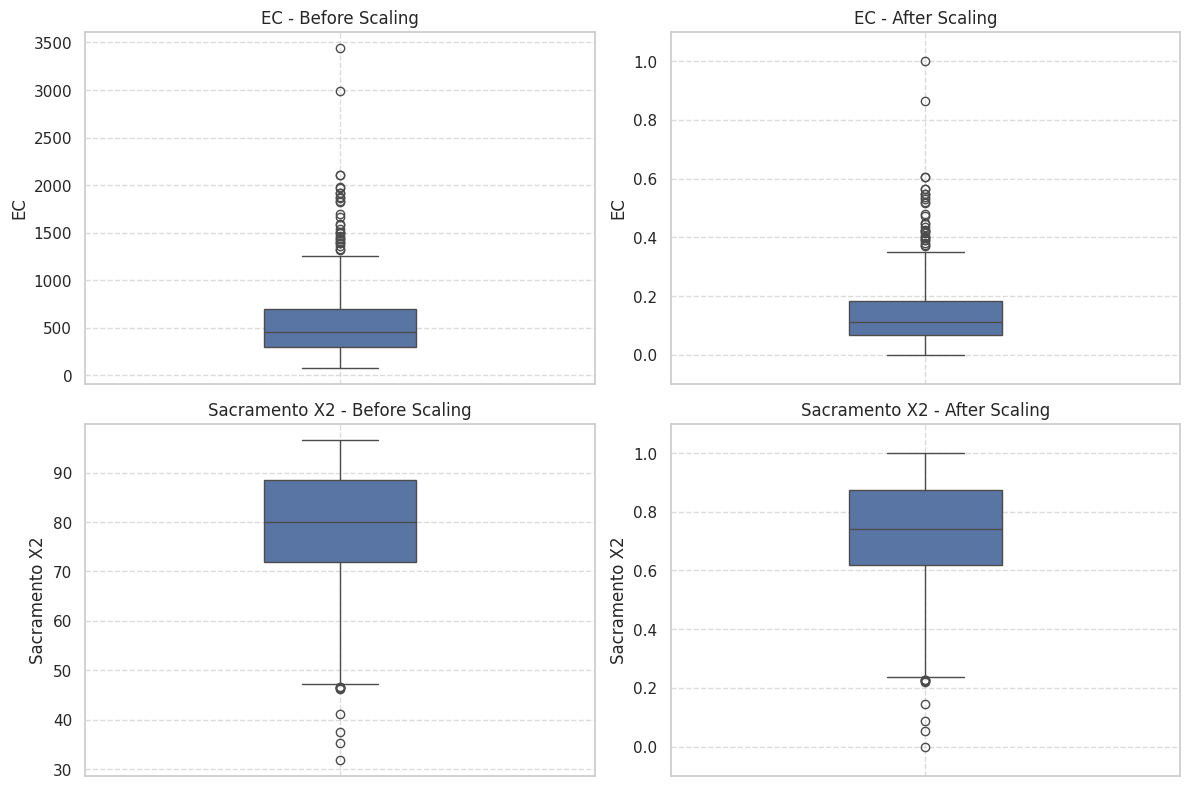

['/content/drive/MyDrive/WorkshopML_Colab/outputs/Br_preprocessor.joblib']

In [ ]:
# ================= PREPROCESSING =================

# Change this to analyze different ions (Br, Ca, Cl, K, Mg, Na, SO4, TDS, Alkalinity)
TARGET_ION = 'Br'

df = ion_dfs[TARGET_ION]

# Extract month from Collection Date for seasonality information
df['Month'] = pd.to_datetime(df['Collection Date']).dt.strftime('%b')  # Convert to month abbreviation (Jan, Feb, etc.)

# Define our features
numerical_features = ['EC', 'Sacramento X2']
categorical_features = ['Location', 'WYT', 'Month']
target = TARGET_ION

# Split data into features (X) and target (y)
X = df.drop(columns=[TARGET_ION])
y = df[TARGET_ION]

# Preprocessing for numerical features
numerical_transformer = Pipeline(steps=[
   ('scaler', MinMaxScaler(feature_range=(0, 1)))  # Scale features between 0 and 1
])

# Create preprocessing steps for categorical features
categorical_transformer = Pipeline(steps=[
   ('onehot', OneHotEncoder(drop='first', sparse_output=False))  # One-hot encode with dropping first category
])

# Combine the transformers using ColumnTransformer
preprocessor = ColumnTransformer(
   transformers=[
       ('num', numerical_transformer, numerical_features),
       ('cat', categorical_transformer, categorical_features)
   ],
   remainder='passthrough'  # Keep other columns
)

# Apply preprocessing to the data
X_preprocessed = preprocessor.fit_transform(X)

# Get the feature names after transformation
ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
categorical_feature_names = []
for i, feature in enumerate(categorical_features):
   feature_categories = ohe.categories_[i][1:]  # Skip the first category (dropped)
   categorical_feature_names.extend([f"{feature}_{category}" for category in feature_categories])

# Combine all feature names
transformed_column_names = numerical_features + categorical_feature_names
remainder_columns = [col for col in X.columns if col not in numerical_features + categorical_features]
all_column_names = transformed_column_names + remainder_columns

# Create a DataFrame with the preprocessed data for easier visualization
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=all_column_names)

# Visualize the effect of scaling on numerical features
fig, axes = plt.subplots(len(numerical_features), 2, figsize=(12, 4*len(numerical_features)))

for i, feature in enumerate(numerical_features):
   # Before preprocessing
   sns.boxplot(y=X[feature], ax=axes[i, 0], width=0.3)
   axes[i, 0].set_title(f'{feature} - Before Scaling')
   axes[i, 0].grid(True, linestyle='--', alpha=0.7)

   # After preprocessing
   sns.boxplot(y=X_preprocessed_df[feature], ax=axes[i, 1], width=0.3)
   axes[i, 1].set_title(f'{feature} - After Scaling')
   axes[i, 1].grid(True, linestyle='--', alpha=0.7)
   axes[i, 1].set_ylim(-0.1, 1.1)

plt.tight_layout()
plt.savefig(f'{output_folder}/{TARGET_ION}_numerical_before_after_comparison.png')
plt.show()

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
   X, y, test_size=0.2, random_state=42
)

# Save the preprocessing pipeline for later use
joblib.dump(preprocessor, f'{output_folder}/{TARGET_ION}_preprocessor.joblib')

In [ ]:
X.head(3)

,Long Station Name,Collection Date,EC,Sacramento X2,Location,WYT,Month
0,Rock Slough @ Old River,1990-01-24,962.0,79.667207,OMR,C,Jan
1,Clifton Court Intake,1990-02-21,472.0,80.129967,OMR,C,Feb
2,Rock Slough @ Old River,1990-02-23,598.0,83.082526,OMR,C,Feb


In [ ]:
X_preprocessed_df.head(3)

,EC,Sacramento X2,Location_SJRcorridor,Location_SouthDelta,WYT_BN,WYT_C,WYT_D,WYT_W,Month_Aug,Month_Dec,...,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,Long Station Name,Collection Date
0,0.262748,0.737252,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Rock Slough @ Old River,1990-01-24
1,0.11714,0.744387,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Clifton Court Intake,1990-02-21
2,0.154582,0.78991,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Rock Slough @ Old River,1990-02-23


## 4. Model Training

Training data shape: (988, 19)
Features used for model training: ['EC', 'Sacramento X2', 'Location_SJRcorridor', 'Location_SouthDelta', 'WYT_BN', 'WYT_C', 'WYT_D', 'WYT_W', 'Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jan', 'Month_Jul', 'Month_Jun', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep']

Training Random Forest for Br...
Random Forest model saved to /content/drive/MyDrive/WorkshopML_Colab/outputs/Br_random_forest_model.joblib

Training XGBoost for Br...
XGBoost model saved to /content/drive/MyDrive/WorkshopML_Colab/outputs/Br_xgboost_model.joblib

Training Neural Network for Br...
Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0703 - val_loss: 0.0501
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0492 - val_loss: 0.0449
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0395 - val_loss: 0.0419
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0507 - val_loss: 0.0392
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 

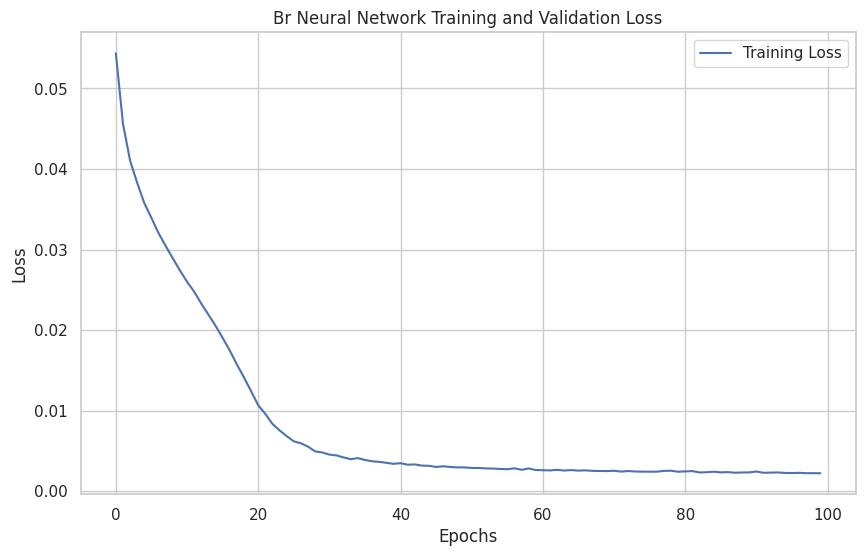

Neural Network model saved to /content/drive/MyDrive/WorkshopML_Colab/outputs/Br_nn_model.h5
Feature names saved to /content/drive/MyDrive/WorkshopML_Colab/outputs/Br_model_feature_names.joblib

All models for Br have been trained and saved successfully!


In [ ]:
# ================= MODEL TRAINING =================

# Load the preprocessing pipeline
preprocessor_path = f'{output_folder}/{TARGET_ION}_preprocessor.joblib'
preprocessor = joblib.load(preprocessor_path)

# Apply preprocessing to the training and test data
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get the processed feature names
ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
categorical_feature_names = []
for i, feature in enumerate(categorical_features):
   feature_categories = ohe.categories_[i][1:]  # Skip the first category (dropped)
   categorical_feature_names.extend([f"{feature}_{category}" for category in feature_categories])

# Create column names for the transformed dataframe
transformed_column_names = numerical_features + categorical_feature_names
remainder_columns = [col for col in X_train.columns if col not in numerical_features + categorical_features]

# Create dataframes with the transformed data
X_train_processed_df = pd.DataFrame(
   X_train_processed,
   columns=transformed_column_names + remainder_columns
)

X_test_processed_df = pd.DataFrame(
   X_test_processed,
   columns=transformed_column_names + remainder_columns
)

# Keep only the numerical and categorical columns for training models
X_train_processed_filtered = X_train_processed_df[transformed_column_names].values.astype(np.float32)
X_test_processed_filtered = X_test_processed_df[transformed_column_names].values.astype(np.float32)

print(f"Training data shape: {X_train_processed_filtered.shape}")
print(f"Features used for model training: {transformed_column_names}")

# ================= MODEL 1: RANDOM FOREST =================
print(f"\nTraining Random Forest for {TARGET_ION}...")

# Random Forest model
rf_model = RandomForestRegressor(
   n_estimators=100,
   max_depth=None,
   min_samples_split=2,
   min_samples_leaf=1,
   random_state=42,
   n_jobs=-1
)

rf_model.fit(X_train_processed_filtered, y_train)

# Save the Random Forest model
rf_model_path = f'{output_folder}/{TARGET_ION}_random_forest_model.joblib'
joblib.dump(rf_model, rf_model_path)
print(f"Random Forest model saved to {rf_model_path}")

# ================= MODEL 2: XGBOOST =================
print(f"\nTraining XGBoost for {TARGET_ION}...")

# XGBoost model
xgb_model = XGBRegressor(
   n_estimators=100,
   learning_rate=0.1,
   max_depth=5,
   subsample=0.8,
   colsample_bytree=0.8,
   random_state=42,
   n_jobs=-1
)

xgb_model.fit(X_train_processed_filtered, y_train)

# Save the XGBoost model
xgb_model_path = f'{output_folder}/{TARGET_ION}_xgboost_model.joblib'
joblib.dump(xgb_model, xgb_model_path)
print(f"XGBoost model saved to {xgb_model_path}")

# ================= MODEL 3: NEURAL NETWORK =================
print(f"\nTraining Neural Network for {TARGET_ION}...")

# Get the number of input features from the filtered data
num_features = X_train_processed_filtered.shape[1]

# network model
nn_model = Sequential([
   Dense(16, activation='relu', input_shape=(num_features,)),
   Dense(8, activation='relu'),
   Dense(4, activation='relu'),
   Dense(1)
])

# Compile the model
nn_model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
   loss='mean_squared_error'
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
   monitor='val_loss',
   patience=20,
   restore_best_weights=True,
   verbose=1
)

# Train the model
history = nn_model.fit(
   X_train_processed_filtered,
   y_train.values.astype(np.float32),
   epochs=100,
   batch_size=32,
   validation_split=0.2,
   callbacks=[early_stopping],
   verbose=1
)

# Plot training & validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.title(f'{TARGET_ION} Neural Network Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(f'{output_folder}/{TARGET_ION}_nn_training_loss.png')
plt.show()

# Save the Neural Network model
nn_model_path = f'{output_folder}/{TARGET_ION}_nn_model.h5'
nn_model.save(nn_model_path)
print(f"Neural Network model saved to {nn_model_path}")

# Save the feature names for future reference
feature_names_path = f'{output_folder}/{TARGET_ION}_model_feature_names.joblib'
joblib.dump(transformed_column_names, feature_names_path)
print(f"Feature names saved to {feature_names_path}")
print(f"\nAll models for {TARGET_ION} have been trained and saved successfully!")

## 5. Evaluation

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Model Evaluation Results:
            Model   Dataset   MAE  Percentage Bias    R2
0   Random Forest  Training  0.01             1.58  0.99
1   Random Forest      Test  0.03             3.83  0.96
2         XGBoost  Training  0.02             3.25  0.99
3         XGBoost      Test  0.03             6.13  0.96
4  Neural Network  Training  0.03             8.87  0.96
5  Neural Network      Test  0.04            12.39  0.94
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


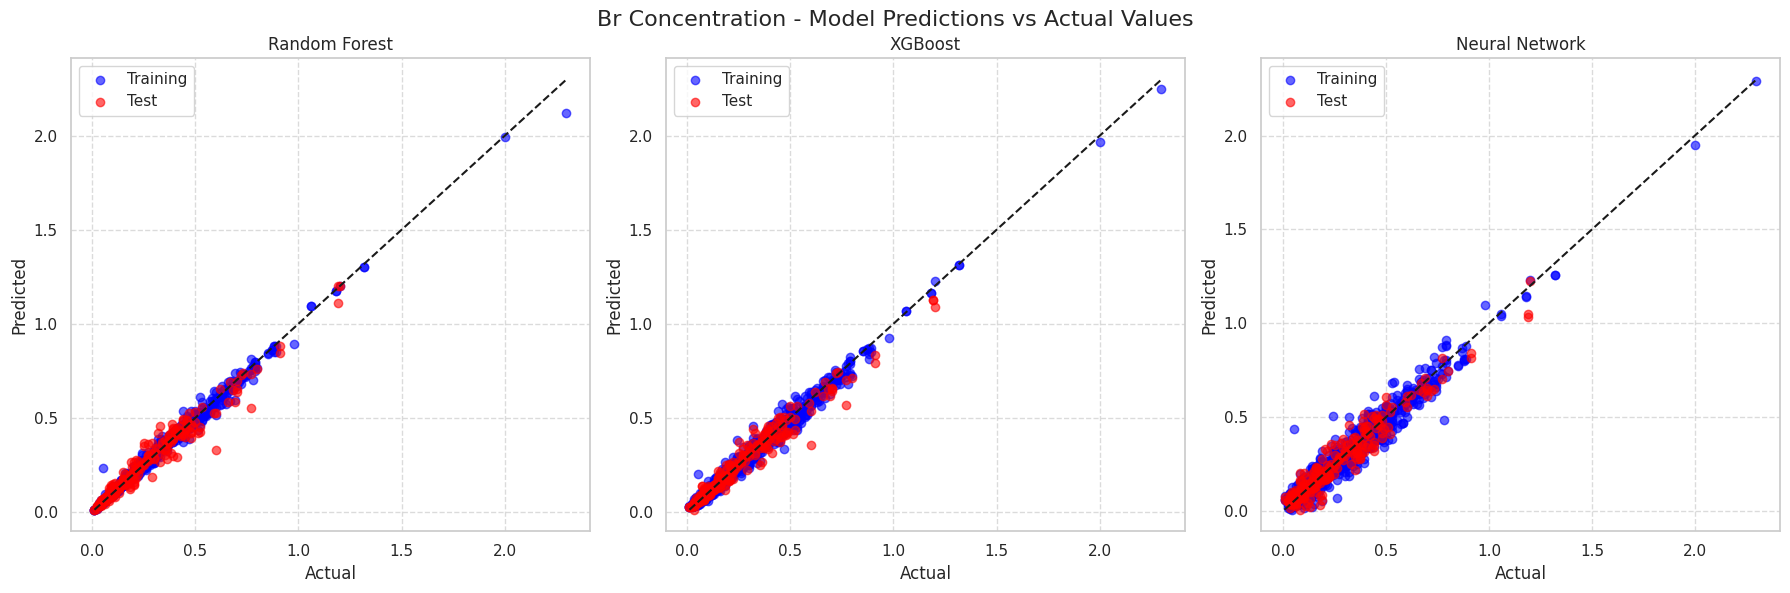

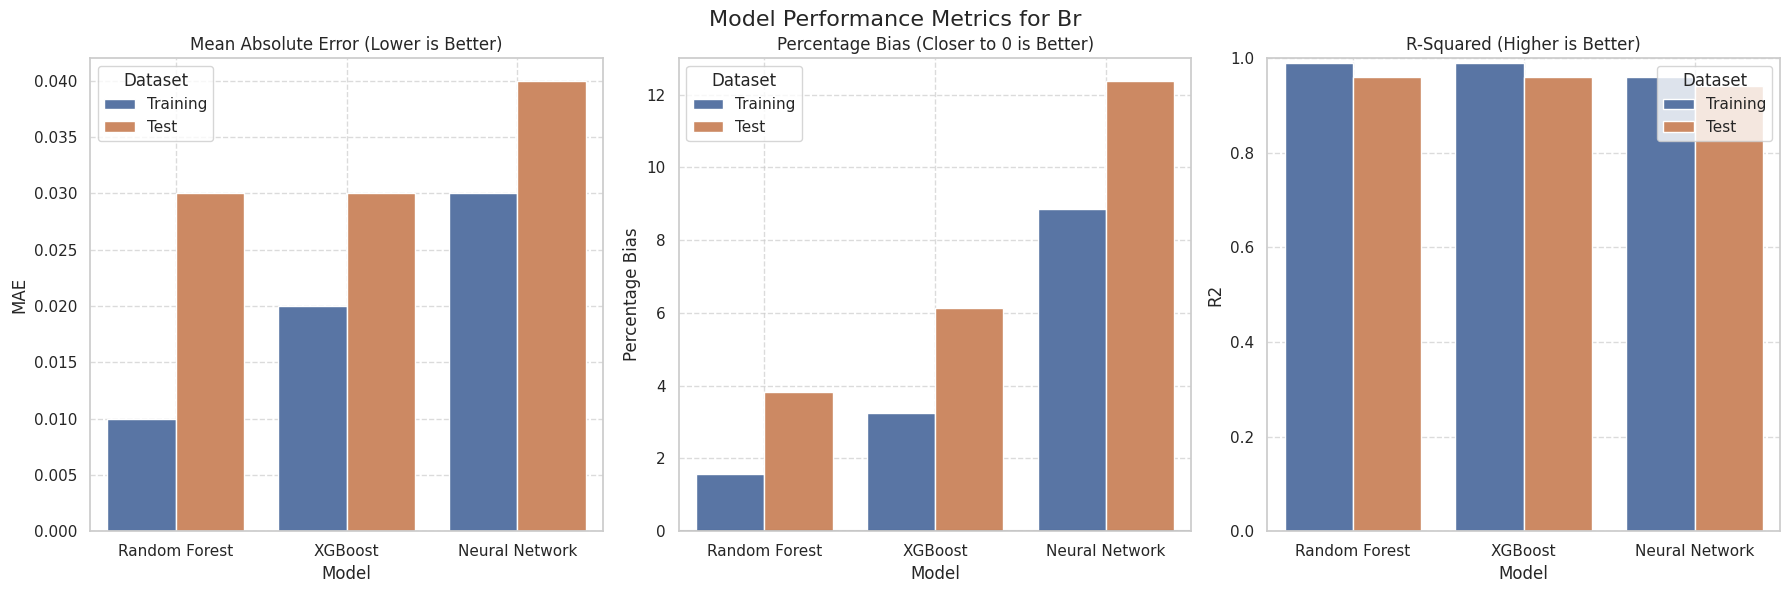

In [ ]:
# ================= MODEL EVALUATION =================

# Load the preprocessor, feature names, and models
preprocessor = joblib.load(f'{output_folder}/{TARGET_ION}_preprocessor.joblib')
feature_names = joblib.load(f'{output_folder}/{TARGET_ION}_model_feature_names.joblib')

# Load the trained models
rf_model = joblib.load(f'{output_folder}/{TARGET_ION}_random_forest_model.joblib')
xgb_model = joblib.load(f'{output_folder}/{TARGET_ION}_xgboost_model.joblib')
nn_model = load_model(f'{output_folder}/{TARGET_ION}_nn_model.h5')

# Apply preprocessing to the training and test data
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Create dataframes with the transformed data
X_train_processed_df = pd.DataFrame(
   X_train_processed,
   columns=feature_names + [col for col in X_train.columns if col not in numerical_features + categorical_features]
)

X_test_processed_df = pd.DataFrame(
   X_test_processed,
   columns=feature_names + [col for col in X_test.columns if col not in numerical_features + categorical_features]
)

# Keep only the features used for model training
X_train_filtered = X_train_processed_df[feature_names].values.astype(np.float32)
X_test_filtered = X_test_processed_df[feature_names].values.astype(np.float32)

# Define a function to calculate evaluation metrics
def calculate_metrics(y_true, y_pred):
   """Calculate MAE, percentage bias, and R2 score"""
   mae = mean_absolute_error(y_true, y_pred)
   percent_bias = np.mean((y_pred - y_true) / y_true) * 100
   r2 = r2_score(y_true, y_pred)  #Generalized R-squared  (Range: -∞ to 1)  coefficient of determination
   return mae, percent_bias, r2

# Make predictions for each model
models = {
   'Random Forest': rf_model,
   'XGBoost': xgb_model,
   'Neural Network': nn_model
}

# Calculate metrics for each model
results = []
for name, model in models.items():
   # Make predictions
   if name == 'Neural Network':
       y_train_pred = model.predict(X_train_filtered).flatten()
       y_test_pred = model.predict(X_test_filtered).flatten()
   else:
       y_train_pred = model.predict(X_train_filtered)
       y_test_pred = model.predict(X_test_filtered)

   # Calculate metrics
   train_mae, train_bias, train_r2 = calculate_metrics(y_train, y_train_pred)
   test_mae, test_bias, test_r2 = calculate_metrics(y_test, y_test_pred)

   # Store results
   results.append({
       'Model': name,
       'Dataset': 'Training',
       'MAE': round(train_mae, 2),
       'Percentage Bias': round(train_bias, 2),
       'R2': round(train_r2, 2)
   })

   results.append({
       'Model': name,
       'Dataset': 'Test',
       'MAE': round(test_mae, 2),
       'Percentage Bias': round(test_bias, 2),
       'R2': round(test_r2, 2)
   })

# Create a DataFrame with the results
results_df = pd.DataFrame(results)

# Display results
print("Model Evaluation Results:")
print(results_df)

# Save evaluation results
results_df.to_csv(f'{output_folder}/{TARGET_ION}_model_evaluation.csv', index=False)

# Create a comparison plot for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f'{TARGET_ION} Concentration - Model Predictions vs Actual Values', fontsize=16)

# Create scatter plots to compare predicted vs actual values
for i, (name, model) in enumerate(models.items()):
   # Get predictions for both training and test sets
   if name == 'Neural Network':
       y_train_pred = model.predict(X_train_filtered).flatten()
       y_test_pred = model.predict(X_test_filtered).flatten()
   else:
       y_train_pred = model.predict(X_train_filtered)
       y_test_pred = model.predict(X_test_filtered)

   # Create scatter plot with blue for training and red for test
   axes[i].scatter(y_train, y_train_pred, alpha=0.6, color='blue', label='Training')
   axes[i].scatter(y_test, y_test_pred, alpha=0.6, color='red', label='Test')

   # Add perfect prediction line
   min_val = min(min(y_train.min(), y_train_pred.min()), min(y_test.min(), y_test_pred.min()))
   max_val = max(max(y_train.max(), y_train_pred.max()), max(y_test.max(), y_test_pred.max()))
   axes[i].plot([min_val, max_val], [min_val, max_val], 'k--')

   # Set labels and title
   axes[i].set_title(f'{name}')
   axes[i].set_xlabel('Actual')
   axes[i].set_ylabel('Predicted')
   axes[i].grid(True, linestyle='--', alpha=0.7)
   axes[i].legend()

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig(f"{output_folder}/{TARGET_ION}_model_comparison.png")
plt.show()

# Visualize the metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f'Model Performance Metrics for {TARGET_ION}', fontsize=16)

# 1. MAE - Mean Absolute Error (lower is better)
sns.barplot(x='Model', y='MAE', hue='Dataset', data=results_df, ax=axes[0])
axes[0].set_title('Mean Absolute Error (Lower is Better)')
axes[0].grid(True, linestyle='--', alpha=0.7)

# 2. Bias - Percentage Bias (closer to 0 is better)
sns.barplot(x='Model', y='Percentage Bias', hue='Dataset', data=results_df, ax=axes[1])
axes[1].set_title('Percentage Bias (Closer to 0 is Better)')
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.3)

# 3. R² - R-Squared (higher is better)
sns.barplot(x='Model', y='R2', hue='Dataset', data=results_df, ax=axes[2])
axes[2].set_title('R-Squared (Higher is Better)')
axes[2].grid(True, linestyle='--', alpha=0.7)
axes[2].set_ylim(0, 1)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig(f'{output_folder}/{TARGET_ION}_model_performance_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Dashboard

In [ ]:
# Define custom style for widgets
widget_style = {
    'background': '#f9f9f9',
    'border': '1px solid #ddd',
    'padding': '10px',
    'border-radius': '5px'
}

# Define location names for display
location_names = {
    'OMR': 'Old River at Old River',
    'SJRcorridor': 'San Joaquin River at Jersey Point',
    'SouthDelta': 'Middle River at Middle River'
}

# Function to make predictions
def predict_ion_concentration(ec, sacramento_x2, location, wyt, month):
    """Make predictions using all three models"""
    try:
        # Create a DataFrame with input values
        input_data = pd.DataFrame({
            'EC': [ec],
            'Sacramento X2': [sacramento_x2],
            'Location': [location],
            'WYT': [wyt],
            'Month': [month],
            'Collection Date': [f"2023-{datetime.strptime(month, '%b').month:02d}-15"],
            'Long Station Name': [location_names.get(location, "Unknown")]
        })

        # Define required model features (in case they're not in global scope)
        numerical_features = ['EC', 'Sacramento X2']
        categorical_features = ['Location', 'WYT', 'Month']

        # Load and apply preprocessor
        preprocessor = joblib.load(f'{output_folder}/{TARGET_ION}_preprocessor.joblib')
        X_processed = preprocessor.transform(input_data)

        # Get feature names and filter processed data
        feature_names = joblib.load(f'{output_folder}/{TARGET_ION}_model_feature_names.joblib')
        X_filtered = pd.DataFrame(X_processed, columns=feature_names +
                                [col for col in input_data.columns
                                 if col not in numerical_features + categorical_features])
        X_filtered = X_filtered[feature_names].values.astype(np.float32)

        # Load models
        rf_model = joblib.load(f'{output_folder}/{TARGET_ION}_random_forest_model.joblib')
        xgb_model = joblib.load(f'{output_folder}/{TARGET_ION}_xgboost_model.joblib')
        nn_model = load_model(f'{output_folder}/{TARGET_ION}_nn_model.h5')

        # Make a dummy prediction with the neural network to build metrics
        # This prevents the warning message
        _ = nn_model.predict(np.zeros((1, X_filtered.shape[1]), dtype=np.float32))

        # Make predictions
        rf_pred = rf_model.predict(X_filtered)[0]
        xgb_pred = xgb_model.predict(X_filtered)[0]
        nn_pred = nn_model.predict(X_filtered).flatten()[0]

        return {
            'Random Forest': rf_pred,
            'XGBoost': xgb_pred,
            'Neural Network': nn_pred
        }
    except Exception as e:
        print(f"Error in prediction: {e}")
        import traceback
        traceback.print_exc()
        return {
            'Random Forest': np.nan,
            'XGBoost': np.nan,
            'Neural Network': np.nan
        }

# Create input widgets
ec_slider = pn.widgets.FloatSlider(
    name='Electrical Conductivity (EC) [µS/cm]',
    start=100,
    end=3500,
    value=1000,
    step=10,
    styles=widget_style
)

sacramento_x2_slider = pn.widgets.FloatSlider(
    name='Sacramento X2',
    start=40,
    end=100,
    value=80,
    step=1,
    styles=widget_style
)

location_select = pn.widgets.Select(
    name='Location',
    options=['OMR', 'SJRcorridor', 'SouthDelta'],
    value='OMR',
    styles=widget_style
)

wyt_select = pn.widgets.Select(
    name='Water Year Type (WYT)',
    options=['W', 'AN', 'BN', 'D', 'C'],
    value='AN',
    styles=widget_style
)

month_select = pn.widgets.Select(
    name='Month',
    options=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    value='Sep',
    styles=widget_style
)

# Output components
prediction_table = pn.pane.HTML(width=500, height=200)
prediction_plot = pn.pane.HoloViews()
status_message = pn.pane.Markdown("Ready to predict", styles={'color': 'blue'})

# Function to update predictions when inputs change
def update_predictions(event):
    # Update status
    status_message.object = "Calculating predictions..."

    # Get input values
    ec = ec_slider.value
    sacramento_x2 = sacramento_x2_slider.value
    location = location_select.value
    wyt = wyt_select.value
    month = month_select.value

    # Make predictions
    predictions = predict_ion_concentration(ec, sacramento_x2, location, wyt, month)

    # Update table
    html_table = f"""
    <div style="background: #f9f9f9; border: 1px solid #ddd; padding: 15px; border-radius: 5px;">
      <h3>Predicted {TARGET_ION} Concentration</h3>
      <table style="width: 100%; border-collapse: collapse;">
        <tr>
          <th style="text-align: left; padding: 8px; border-bottom: 2px solid #ddd;">Model</th>
          <th style="text-align: right; padding: 8px; border-bottom: 2px solid #ddd;">{TARGET_ION} (mg/L)</th>
        </tr>
        <tr>
          <td style="text-align: left; padding: 8px; border-bottom: 1px solid #ddd;">Random Forest</td>
          <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">{predictions['Random Forest']:.2f}</td>
        </tr>
        <tr>
          <td style="text-align: left; padding: 8px; border-bottom: 1px solid #ddd;">XGBoost</td>
          <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">{predictions['XGBoost']:.2f}</td>
        </tr>
        <tr>
          <td style="text-align: left; padding: 8px; border-bottom: 1px solid #ddd;">Neural Network</td>
          <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">{predictions['Neural Network']:.2f}</td>
        </tr>
      </table>
    </div>
    """
    prediction_table.object = html_table

    # Create bar chart
    result_df = pd.DataFrame({
        'Model': list(predictions.keys()),
        'Prediction': list(predictions.values())
    })

    # Define specific colors for each model
    model_colors = {
        'Random Forest': '#1f77b4',  # blue
        'XGBoost': '#ff7f0e',        # orange
        'Neural Network': '#2ca02c'   # green
    }

    bar_chart = result_df.hvplot.bar(
        x='Model',
        y='Prediction',
        color='Model',
        cmap=model_colors,  # Use the custom color mapping
        ylim=(0, None),
        ylabel=f'{TARGET_ION} Concentration (mg/L)',
        title=f'Predicted {TARGET_ION} for {location}, {month}, WYT: {wyt}',
        height=400,
        width=600
    )

    prediction_plot.object = bar_chart
    status_message.object = "Predictions updated"

# Connect input changes to updates
for widget in [ec_slider, sacramento_x2_slider, location_select, wyt_select, month_select]:
    widget.param.watch(update_predictions, 'value')

# Create dashboard title and description
title = pn.pane.Markdown(f"""
# {TARGET_ION} Concentration Prediction Dashboard

This dashboard uses three machine learning models to predict {TARGET_ION} concentration based on
environmental parameters. Adjust the sliders and dropdown menus to see how different conditions
affect predicted {TARGET_ION} levels.
""")

# Create information panel
info_panel = pn.pane.Markdown("""
### Parameter Information

- **Electrical Conductivity (EC)**: Measure of water's ability to conduct electricity, related to dissolved ions. Units: μS/cm.
- **Sacramento X2**: Distance from Golden Gate Bridge to the location where salinity is 2 parts per thousand.
- **Location**: Monitoring station in the Delta.
- **Water Year Type (WYT)**: Classification of water conditions:
  - W: Wet
  - AN: Above Normal
  - BN: Below Normal
  - D: Dry
  - C: Critical
- **Month**: Time of year for prediction.
""")

# Publicly available dashboards info
dashboards_info = pn.pane.Markdown("""
### Our Publicly Available Dashboards

| Dashboard | ID | Web Link |
|-----------|-------|---------|
| Interior Delta Dashboard | DD1 | [https://dwrdashion.azurewebsites.net/Dashboard](https://dwrdashion.azurewebsites.net/Dashboard) |
| Interpretability Dashboard | DD2 | [https://dwrdashionsensitivity.azurewebsites.net/Sensitivity_IonStudy](https://dwrdashionsensitivity.azurewebsites.net/Sensitivity_IonStudy) |
| Water Intake Locations Dashboard | DD3 | [https://dwrdashionintake.azurewebsites.net/Intake_dashboard](https://dwrdashionintake.azurewebsites.net/Intake_dashboard) |
""", styles={'background': '#f0f0f0', 'padding': '10px', 'border-radius': '5px', 'margin-top': '20px'})

# Footer with disclaimer
footer = pn.pane.Markdown("""
---
**Disclaimer:** This dashboard is for educational purposes only. Predictions are based on models trained
with historical data and may not reflect current or future conditions.

*Created as part of the Machine Learning Workshop*
""")

# Contact information
contact_info = pn.pane.Markdown("""
---
**For questions or feedback, please contact:**
Peyman Namadi (peyman.hosseinzadehnamadi@water.ca.gov)
Kevin He (kevin.he@water.ca.gov)
""", styles={'font-size': '14px', 'margin-top': '20px'})

# Create dashboard layout
dashboard = pn.Column(
    title,
    pn.Row(
        # Inputs panel
        pn.Column(
            pn.pane.Markdown("### Input Parameters"),
            ec_slider,
            sacramento_x2_slider,
            location_select,
            wyt_select,
            month_select,
            status_message,
            width=350
        ),
        # Results panel
        pn.Column(
            pn.pane.Markdown("### Prediction Results"),
            prediction_table,
            prediction_plot,
            width=650
        ),
    ),
    pn.Row(
        pn.Column(info_panel, width=1000)
    ),
    dashboards_info,
    footer,
    contact_info
)

# For Colab, we need to use servable() instead of show()
dashboard.servable()

# Trigger initial prediction
update_predictions(None)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [30]:
dashboard

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step 
 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step 
 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step 
 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step 
 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step 
 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step 
 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step 
 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

Column
    [0] Markdown(str)
    [1] Row
        [0] Column(width=350)
            [0] Markdown(str)
            [1] FloatSlider(end=3500, name='Electrical Conductivity (..., start=100, step=10, styles={'background': '#f9f9f9', ...}, value=1000)
            [2] FloatSlider(end=100, name='Sacramento X2', start=40, step=1, styles={'background': '#f9f9f9', ...}, value=72)
            [3] Select(name='Location', options=['OMR', 'SJRcorridor', ...], styles={'background': '#f9f9f9', ...}, value='OMR')
            [4] Select(name='Water Year Type (WYT)', options=['W', 'AN', 'BN', ...], styles={'background': '#f9f9f9', ...}, value='AN')
            [5] Select(name='Month', options=['Jan', 'Feb', ...], styles={'background': '#f9f9f9', ...}, value='Sep')
            [6] Markdown(str, styles={'color': 'blue'})
        [1] Column(width=650)
            [0] Markdown(str)
            [1] HTML(str, height=200, sizing_mode='fixed', width=500)
            [2] HoloViews(Bars, height=400, sizing_mode='fixed', width=600)
    [2] Row
        [0] Column(width=1000)
            [0] Markdown(str)
    [3] Markdown(str, styles={'background': '#f0f0f0', ...})
    [4] Markdown(str)
    [5] Markdown(str, styles={'font-size': '14px', ...})